## **Librerias**

Importacion de librerias

In [10]:
import os
import gym

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import namedtuple

import json
import time
from itertools import count
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from tqdm.notebook import trange

from typing import Any
import re
import json


## **Modelo DQN**



Este código define una clase llamada DQN, que representa una Deep Q-Network (Red Q Profunda). Este es un tipo de red neuronal comúnmente utilizado en el aprendizaje por refuerzo.

La clase DQN define una red neuronal que toma un estado como entrada y predice el valor Q para cada acción posible. Estos valores Q son estimaciones de la recompensa futura esperada por tomar cada acción en ese estado. El agente luego elegirá la acción con el valor Q más alto. La red aprende ajustando sus pesos para mejorar la precisión de sus predicciones de valores Q.

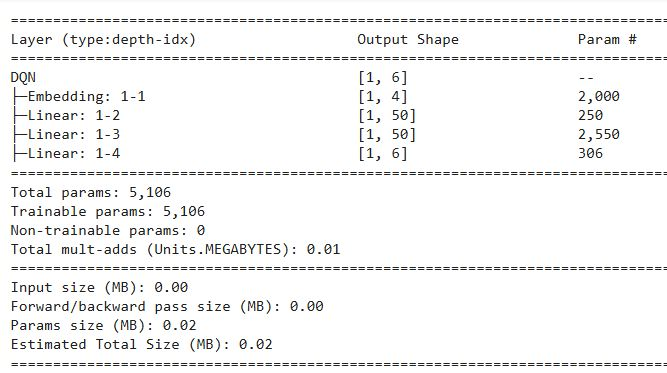

In [2]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.emb = nn.Embedding(500, 4)
        self.l1 = nn.Linear(4, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, outputs)

    def forward(self, x):
        x = F.relu(self.l1(self.emb(x)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

## **Memoria**

Este código define un componente crucial en el Aprendizaje por Refuerzo llamado Memoria de Repetición (Replay Memory). Es esencialmente un sistema de almacenamiento para las experiencias del agente, que luego se utilizan para el entrenamiento.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.rng = np.random.default_rng()

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        idx = self.rng.choice(np.arange(len(self.memory)), batch_size, replace=False)
        res = []
        for i in idx:
            res.append(self.memory[i])
        return res
        #

    def __len__(self):
        return len(self.memory)

## **Configuración Hiperparámetros**

Este código define varias clases que se utilizan para almacenar y administrar la configuración del algoritmo de aprendizaje por refuerzo. Estas clases ayudan a organizar y acceder a los diversos parámetros que controlan el proceso de entrenamiento.

In [4]:
class TrainingConfig():
    def __init__(self, config:dict=None)-> None:
        self.batch_size = config.get("batch_size")
        self.learning_rate = config.get("learning_rate")
        self.loss = config.get("loss")
        self.num_episodes = config.get("num_episodes")
        self.train_steps = config.get("train_steps")
        self.warmup_episode = config.get("warmup_episode")
        self.save_freq = config.get("save_freq")

class OptimizerConfig():
    def __init__(self, config:dict=None)-> None:
        self.name = config.get("name")
        self.lr_min = config.get("lr_min")
        self.lr_decay = config.get("lr_decay")

class RlConfig():
    def __init__(self, config:dict=None) -> None:
        self.gamma = config.get("gamma")
        self.max_steps_per_episode = config.get("max_steps_per_episode")
        self.target_model_update_episodes = config.get("target_model_update_episodes")
        self.max_queue_length = config.get("max_queue_length")

class EpsilonConfig():
    def __init__(self, config:dict=None) -> None:
        self.max_epsilon = config.get("max_epsilon")
        self.min_epsilon = config.get("min_epsilon")
        self.decay_epsilon = config.get("decay_epsilon")

class Config:
    """ User config class """
    def __init__(self, path: str=None):
            self.training = TrainingConfig(config.get("training", {}))
            self.optimizer = OptimizerConfig(config.get("optimizer", {}))
            self.rl = RlConfig(config.get("rl", {}))
            self.epsilon = EpsilonConfig(config.get("epsilon", {}))

## **Agente DQN**

La clase QAgent está diseñada para implementar un agente de Q-learning, un tipo de algoritmo de aprendizaje por refuerzo.


En términos simples, un agente de Q-learning aprende a tomar decisiones en un entorno probando diferentes acciones y observando las recompensas que recibe. Almacena estas experiencias en su memoria y las utiliza para mejorar su estrategia de toma de decisiones con el tiempo.



In [5]:
class QAgent():
    def __init__(self, env, config, model_class):
        self.env = env
        self.model_dir = Path('./sample_data')
        self.model_class = model_class
        self.config_file = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.episode_durations = []
        self.config = Config(self.config_file)
        self.memory = None
        self.rng = np.random.default_rng(42)
        self.episode_durations = []
        self.reward_in_episode = []
        self.epsilon_vec = []
        self.loss = None
        self.last_step = 0
        self.last_episode = 0
        self.id = int(time.time())

        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)

    def _get_optimizer(self):
        try:
            if self.config.optimizer.lower() == "adam":
                return optim.Adam(self.model.parameters(), lr=self.config.training.learning_rate)
            elif self.config.optimizer.lower() == "adadelta":
                return optim.Adadelta(self.model.parameters(), lr=self.config.training.learning_rate)
            elif self.config.optimizer.lower() == "rms":
                return optim.RMSprop(self.model.parameters(), lr=self.config.training.learning_rate)
            else:
                return optim.Adam(self.model.parameters(), lr=self.config.training.learning_rate)
        except AttributeError:
            return optim.Adam(self.model.parameters(), lr=self.config.training.learning_rate)

    def compile(self):
        n_actions = self.env.action_space.n

        self.model = self.model_class(n_actions).to(self.device)
        self.target_model = self.model_class(n_actions).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        self.optimizer = self._get_optimizer()

    def _get_epsilon(self, episode):
        epsilon = self.config.epsilon.min_epsilon + \
                          (self.config.epsilon.max_epsilon - self.config.epsilon.min_epsilon) * \
                              np.exp(-episode / self.config.epsilon.decay_epsilon)
        return epsilon

    def _get_action_for_state(self, state):
        with torch.no_grad():
            predicted = self.model(torch.tensor([state], device=self.device))
            action = predicted.max(1)[1]
        return action.item()

    def _choose_action(self, state, epsilon):
        if self.rng.uniform() < epsilon:
            # Explorar
            action = self.env.action_space.sample()
        else:
            # Explotar
            action = self._get_action_for_state(state)
        return action

    def _adjust_learning_rate(self, episode):
        delta = self.config.training.learning_rate - self.config.optimizer.lr_min
        base = self.config.optimizer.lr_min
        rate = self.config.optimizer.lr_decay
        lr = base + delta * np.exp(-episode / rate)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _train_model(self):
        if len(self.memory) < self.config.training.batch_size:
            return
        transitions = self.memory.sample(self.config.training.batch_size)

        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        # Computar los valores Q predicidos
        predicted_q_value = self.model(state_batch).gather(1, action_batch.unsqueeze(1))

        # Computar los valores Q esperados
        next_state_values= self.target_model(next_state_batch).max(1)[0]
        expected_q_values = (~done_batch * next_state_values * self.config.rl.gamma) + reward_batch

        # Computar Perdida
        loss = self.loss(predicted_q_value, expected_q_values.unsqueeze(1))

        # Optimizar el modelo
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def _update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def _remember(self, state, action, next_state, reward, done):
        self.memory.push(torch.tensor([state], device=self.device),
                        torch.tensor([action], device=self.device, dtype=torch.long),
                        torch.tensor([next_state], device=self.device),
                        torch.tensor([reward], device=self.device),
                        torch.tensor([done], device=self.device, dtype=torch.bool))

    def _get_loss(self):
        try:
            if self.config.training.loss.lower() == "huber":
                return F.smooth_l1_loss
            elif self.config.training.loss.lower() == "mse":
                return F.mse_loss
            else:
                return F.smooth_l1_loss
        except AttributeError:
            return F.smooth_l1_loss

    def fit(self):
        try:
            self.config = Config(self.config_file)
            self.loss = self._get_loss()
            self.memory = ReplayMemory(self.config.rl.max_queue_length)

            self.episode_durations = []
            self.reward_in_episode = []
            self.epsilon_vec = []
            reward_in_episode = 0
            epsilon = 1

            progress_bar = trange(0,
                                  self.config.training.num_episodes,
                                  initial=self.last_episode,
                                  total=self.config.training.num_episodes)

            for i_episode in progress_bar:
                # Inicializar el ambiente
                state = self.env.reset()
                if i_episode >= self.config.training.warmup_episode:
                    epsilon = self._get_epsilon(i_episode - self.config.training.warmup_episode)

                for step in count():
                    # Seleccionar y ejecutar una accion.
                    action = self._choose_action(state, epsilon)
                    next_state, reward, done, _ = self.env.step(action)


                    # Almacenar la transicion en memoria.
                    self._remember(state, action, next_state, reward, done)


                    # Ejecutar un paso de la optimizacion (sobre la red destino)
                    if i_episode >= self.config.training.warmup_episode:
                        self._train_model()
                        self._adjust_learning_rate(i_episode - self.config.training.warmup_episode + 1)
                        done = (step == self.config.rl.max_steps_per_episode - 1) or done
                    else:
                        done = (step == 5 * self.config.rl.max_steps_per_episode - 1) or done


                    # Mover al siguiente estado
                    state = next_state
                    reward_in_episode += reward

                    if done:
                        self.episode_durations.append(step + 1)
                        self.reward_in_episode.append(reward_in_episode)
                        self.epsilon_vec.append(epsilon)
                        reward_in_episode = 0
                        N = min(10, len(self.episode_durations))
                        progress_bar.set_postfix({
                            "reward": np.mean(self.reward_in_episode[-N:]),
                            "steps": np.mean(self.episode_durations[-N:]),
                            "epsilon": epsilon
                            })
                        self.plot_durations()
                        break

                # Actualizar la red destino, copiando todos los pesos y bias en DQN.
                if i_episode % self.config.rl.target_model_update_episodes == 0:
                    self._update_target()

                if i_episode % self.config.training.save_freq == 0:
                    self.save()

                self.last_episode = i_episode

        except KeyboardInterrupt:
            self.plot_durations()
            print("Training has been interrupted")

    @staticmethod
    def _moving_average(x, periods=5):
        if len(x) < periods:
            return x
        cumsum = np.cumsum(np.insert(x, 0, 0))
        res = (cumsum[periods:] - cumsum[:-periods]) / periods
        return np.hstack([x[:periods-1], res])

    def plot_durations(self):
        lines = []
        fig = plt.figure(1, figsize=(15, 7))
        plt.clf()
        ax1 = fig.add_subplot(111)

        plt.title('Entrenamiento...')
        ax1.set_xlabel('Episodios')
        ax1.set_ylabel('Duración & Recompensas')
        ax1.set_ylim(-2 * self.config.rl.max_steps_per_episode, self.config.rl.max_steps_per_episode + 10)
        ax1.plot(self.episode_durations, color="C3", alpha=0.2)
        ax1.plot(self.reward_in_episode, color="C0", alpha=0.2)
        mean_steps = self._moving_average(self.episode_durations, periods=5)
        mean_reward = self._moving_average(self.reward_in_episode, periods=5)
        lines.append(ax1.plot(mean_steps, label="Pasos", color="C3")[0])
        lines.append(ax1.plot(mean_reward, label="Recompensa", color="C0")[0])


        ax2 = ax1.twinx()
        ax2.set_ylabel('Epsilon')
        lines.append(ax2.plot(self.epsilon_vec, label="epsilon", color="C5")[0])
        labs = [l.get_label() for l in lines]
        ax1.legend(lines, labs, loc=3)



    def save(self):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            "reward_in_episode": self.reward_in_episode,
            "episode_durations": self.episode_durations,
            "epsilon_vec": self.epsilon_vec,
            "config": self.config
            }, f"{self.model_dir}/pytorch_{self.id}.pt")

    def play(self, verbose:bool=False, sleep:float=0.2, max_steps:int=100):
        # Play an episode
        try:
            actions_str = ["South", "North", "East", "West", "Pickup", "Dropoff"]

            iteration = 0
            state = self.env.reset()  # reset ambiente a nuevo, estado aleatorio
            self.env.render()
            if verbose:
                print(f"Iter: {iteration} - Action: *** - Reward ***")
            time.sleep(sleep)
            done = False

            while not done:
                action = self._get_action_for_state(state)
                iteration += 1
                state, reward, done, info = self.env.step(action)
                display.clear_output(wait=True)
                self.env.render()
                if verbose:
                    print(f"Iter: {iteration} - Action: {action}({actions_str[action]}) - Reward {reward}")
                time.sleep(sleep)
                if iteration == max_steps:
                    print("cannot converge :(")
                    break
        except KeyboardInterrupt:
            pass

    def evaluate(self, max_steps:int=100):
        try:
            total_steps, total_penalties = 0, 0
            episodes = 100

            for episode in trange(episodes):
                state = self.env.reset()  # reset ambiente a nuevo, estado aleatorio
                nb_steps, penalties, reward = 0, 0, 0

                done = False

                while not done:
                    action = self._get_action_for_state(state)
                    state, reward, done, info = self.env.step(action)

                    if reward == -10:
                        penalties += 1

                    nb_steps += 1
                    if nb_steps == max_steps:
                        done = True

                total_penalties += penalties
                total_steps += nb_steps

            print(f"Results after {episodes} episodes:")
            print(f"Average timesteps per episode: {total_steps / episodes}")
            print(f"Average penalties per episode: {total_penalties / episodes}")
        except KeyboardInterrupt:
            pass

## **PRUEBAS VARIAS CON AJUSTES DE HIPERPARAMETROS**

## **Batch_size_alto_512**

Se define un diccionario en Python llamado config_batch_alto. Este diccionario almacena los ajustes de configuración para un algoritmo de aprendizaje por refuerzo, específicamente para el entrenamiento de una Red Q Profunda (DQN).

Estos parametros esta definido por los siguientes valores:

*ENTRENAMIENTO*

batch_size (tamaño del lote): 512. Determina el número de experiencias que se toman de la memoria de repetición para entrenar la DQN en cada iteración. Un tamaño de lote mayor puede llevar a un aprendizaje más estable, pero requiere más memoria.

learning_rate (tasa de aprendizaje): 0.001. Controla cuánto se ajustan los pesos de la DQN durante el entrenamiento. Una tasa de aprendizaje menor significa un aprendizaje más lento, pero potencialmente más estable.

loss (pérdida): "huber". Especifica la función de pérdida utilizada para medir la diferencia entre los valores Q predichos por la DQN y los valores Q objetivo. "huber" se refiere a la pérdida de Huber, que es menos sensible a valores atípicos que la pérdida del error cuadrático medio (MSE).
        

num_episodes (número de episodios): 10000. Establece el número total de episodios (interacciones completas con el entorno) que el agente atravesará durante el entrenamiento.

warmup_episode (episodios de calentamiento): 10. Indica el número de episodios iniciales donde el agente explora aleatoriamente antes de comenzar a aprender usando la DQN.

save_freq (frecuencia de guardado): 1000. Determina con qué frecuencia (en términos de episodios) se guardará el progreso del modelo entrenado en un archivo.

*OPTIMIZADOR*


name (nombre): "adam". Especifica el algoritmo de optimización utilizado para actualizar los pesos de la DQN. "adam" se refiere al optimizador Adam, una opción popular para modelos de aprendizaje profundo.

lr_min (tasa de aprendizaje mínima): 0.0001. Establece la tasa de aprendizaje mínima a la que el optimizador puede decaer.
    
lr_decay (decaimiento de la tasa de aprendizaje): 5000. Controla la velocidad a la que la tasa de aprendizaje disminuye con el tiempo.

*APRENDIZAJE POR REFUERZO (RL)*


gamma (factor de descuento): 0.99. Es el factor de descuento, que determina cuánto valora el agente las recompensas futuras en comparación con las recompensas inmediatas. Un valor cercano a 1 significa que el agente considera las recompensas futuras casi tan importantes como las inmediatas.
    
max_steps_per_episode (máximos pasos por episodio): 100. Limita el número de pasos que el agente puede dar en un solo episodio.

target_model_update_episodes (episodios de actualización del modelo objetivo): 20. Controla la frecuencia con la que se actualizan los pesos de la DQN objetivo con los pesos de la DQN principal. La DQN objetivo se utiliza para proporcionar objetivos estables para que la DQN principal aprenda.
    
max_queue_length (longitud máxima de la cola): 50000. Establece el tamaño máximo de la memoria de repetición, que almacena las experiencias del agente.

*EPSILON*


max_epsilon (epsilon máximo): 1. Es el valor inicial de epsilon en la estrategia de exploración epsilon-greedy. Epsilon representa la probabilidad de que el agente realice una acción aleatoria en lugar de la acción predicha por la DQN.
    
min_epsilon (epsilon mínimo): 0.1. Es el valor mínimo al que epsilon puede decaer.
    
decay_epsilon (decaimiento de epsilon): 400. Controla la velocidad a la que epsilon disminuye con el tiempo, haciendo que el agente explore menos y explote más a medida que aprende.




In [ ]:
config_batch_alto = {
  "training":{
    "batch_size": 512,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-6-b202c57e2171>:208: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


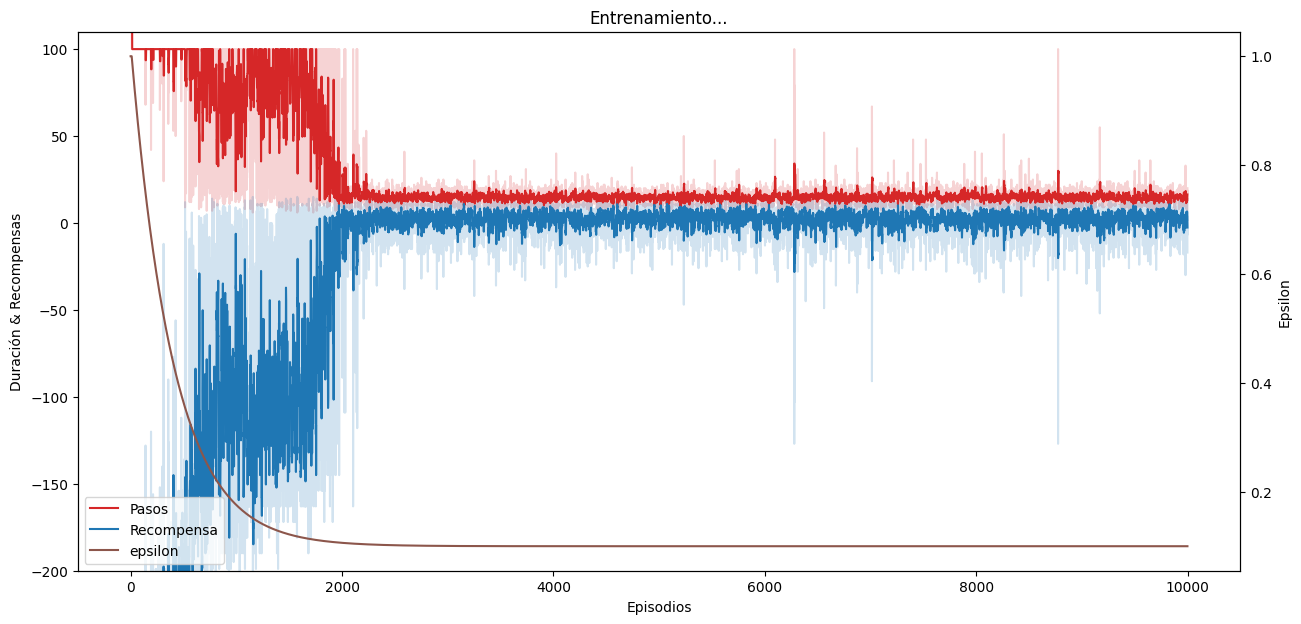

In [ ]:
env = gym.make("Taxi-v3").env
env.seed(100)
config = config_batch_alto
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Batch_size_Bajo_32**

Se define un valor de batch_size: 32.

In [ ]:
config_batch_bajo = {
  "training":{
    "batch_size": 32,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

In [ ]:
env = gym.make("Taxi-v3").env
env.seed(100)
config = config_batch_bajo
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

NameError: name 'gym' is not defined

## **Learning_Rate_Alto_0.01**



Se define un valor de Learning_rate de 0.01

In [ ]:
config_lr_alto = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.01,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.01,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-23-b30617a3d73f>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


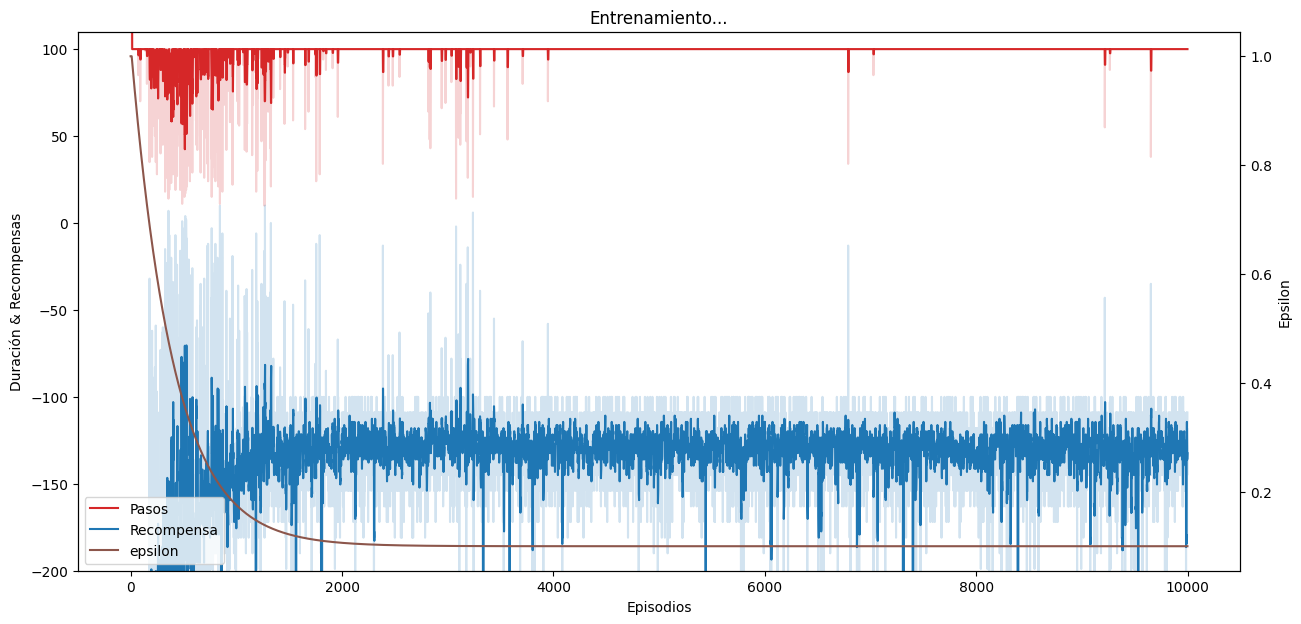

In [ ]:
env = gym.make("Taxi-v3").env
env.seed(100)
config = config_lr_alto
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Learning_Rate_Bajo_0.0001**

Se define un valor de Learning_rate de 0.0001

In [6]:
config_lr_bajo = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.0001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-5-8080a4ff2a66>:208: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


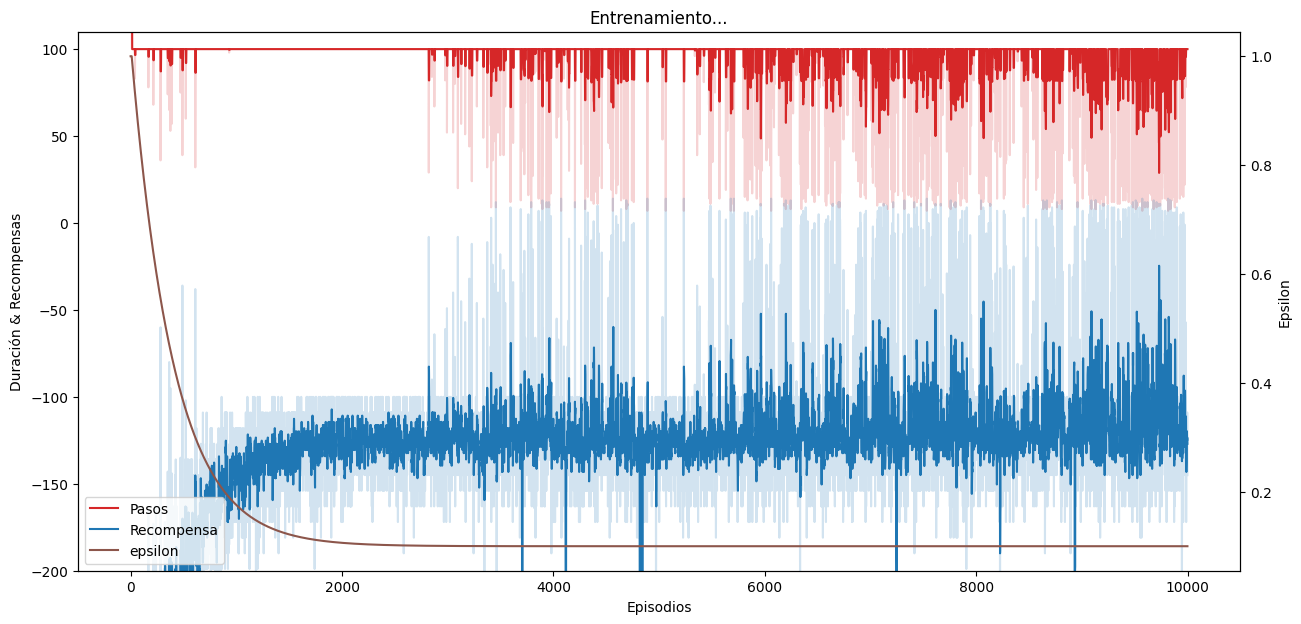

In [7]:
env = gym.make("Taxi-v3").env
env.seed(100)
config = config_lr_bajo
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Epsilon_Alto_0.5**

Se define un valor de Epsilon de 0.5

In [ ]:
config_Epsilon_Alto = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.5,
    "decay_epsilon": 400
    }
  }

  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-10-5d86e1ea47d6>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


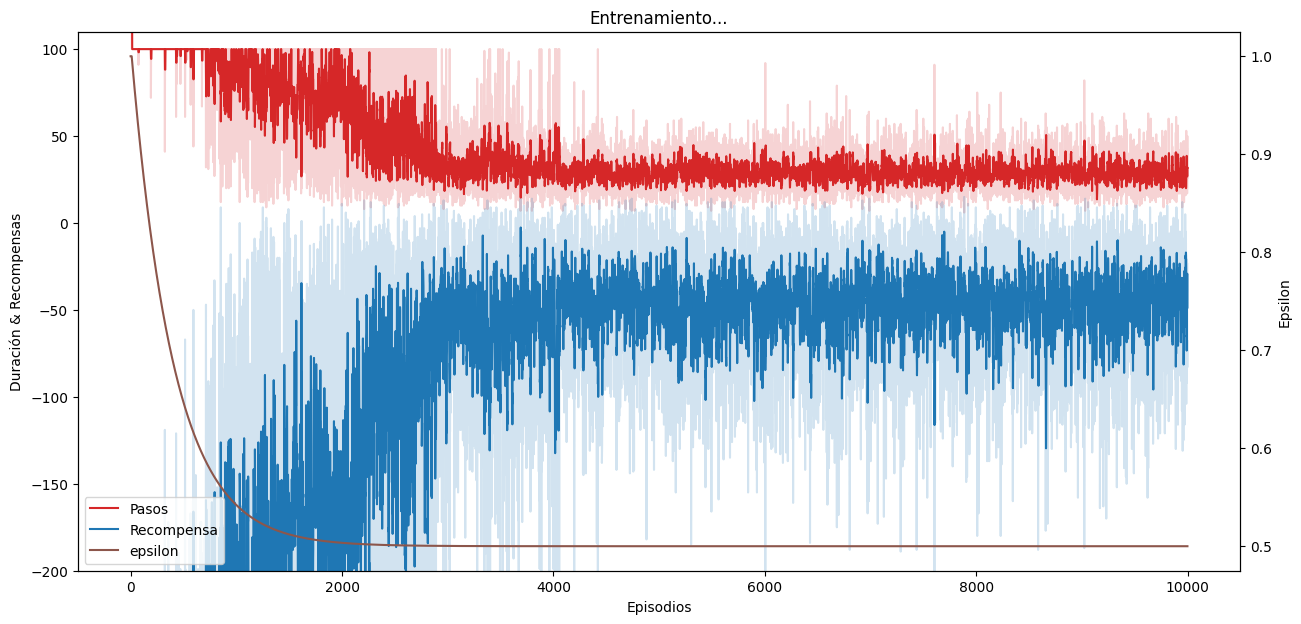

In [ ]:
env = gym.make("Taxi-v3").env
#env.seed(100)
config = config_Epsilon_Alto
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Epsilon_Bajo_0.01**

Se define un valor de epsilon de 0.01

In [ ]:
config_Epsilon_Bajo = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.01,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-10-5d86e1ea47d6>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


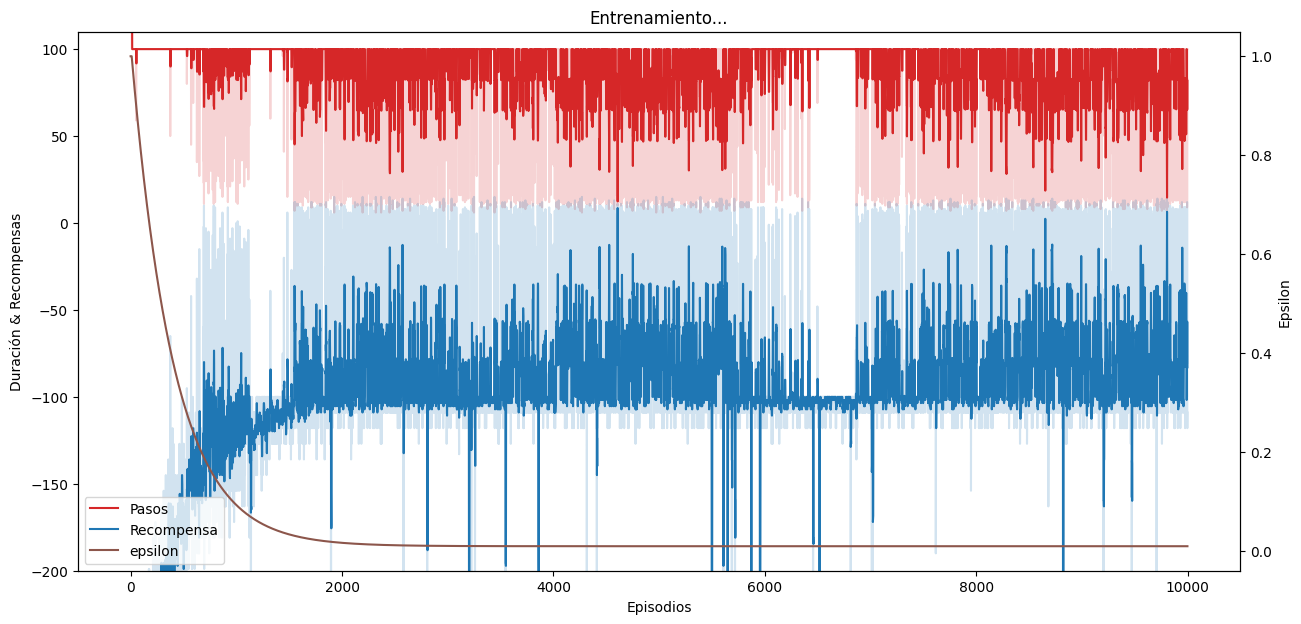

In [ ]:
env = gym.make("Taxi-v3").env
config = config_Epsilon_Bajo
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Gamma_Alto_0.99**

Se define un valor de gamma de 0.99

In [ ]:
config_gamma_alto = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-23-b30617a3d73f>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


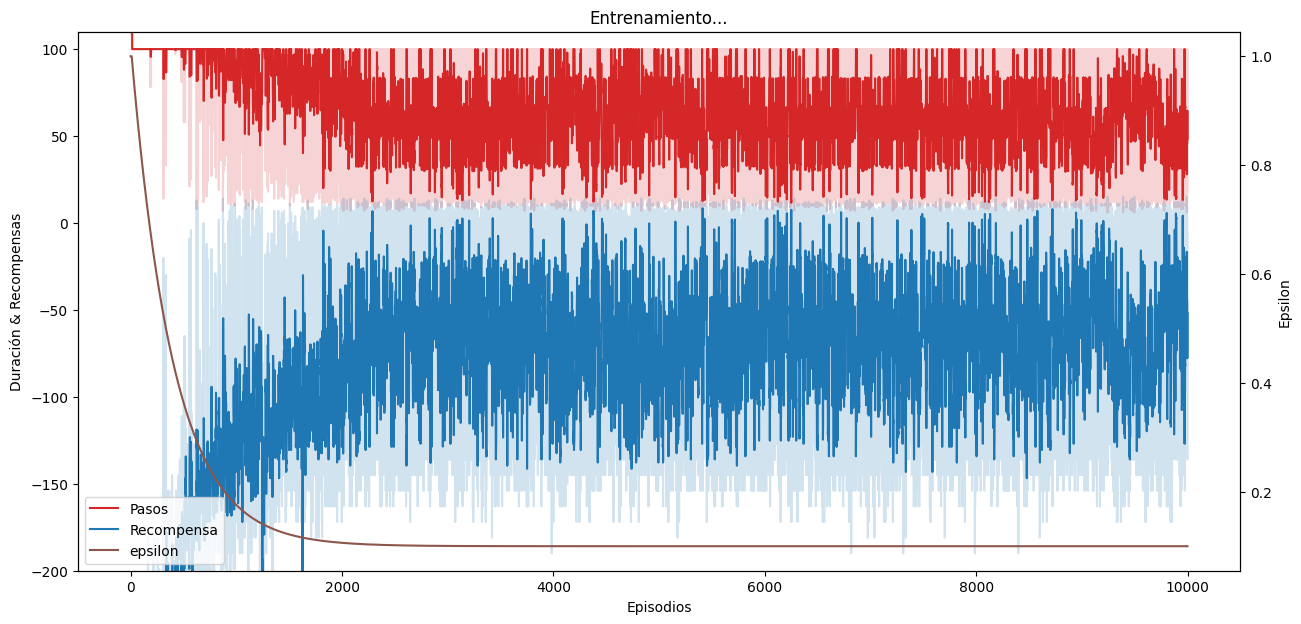

In [ ]:
env = gym.make("Taxi-v3").env
config = config_gamma_alto
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Gamma_Bajo_0.2**

Se define un valor de gamma de 0.2

In [ ]:
config_gamma_bajo = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.2,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 20,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-23-b30617a3d73f>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


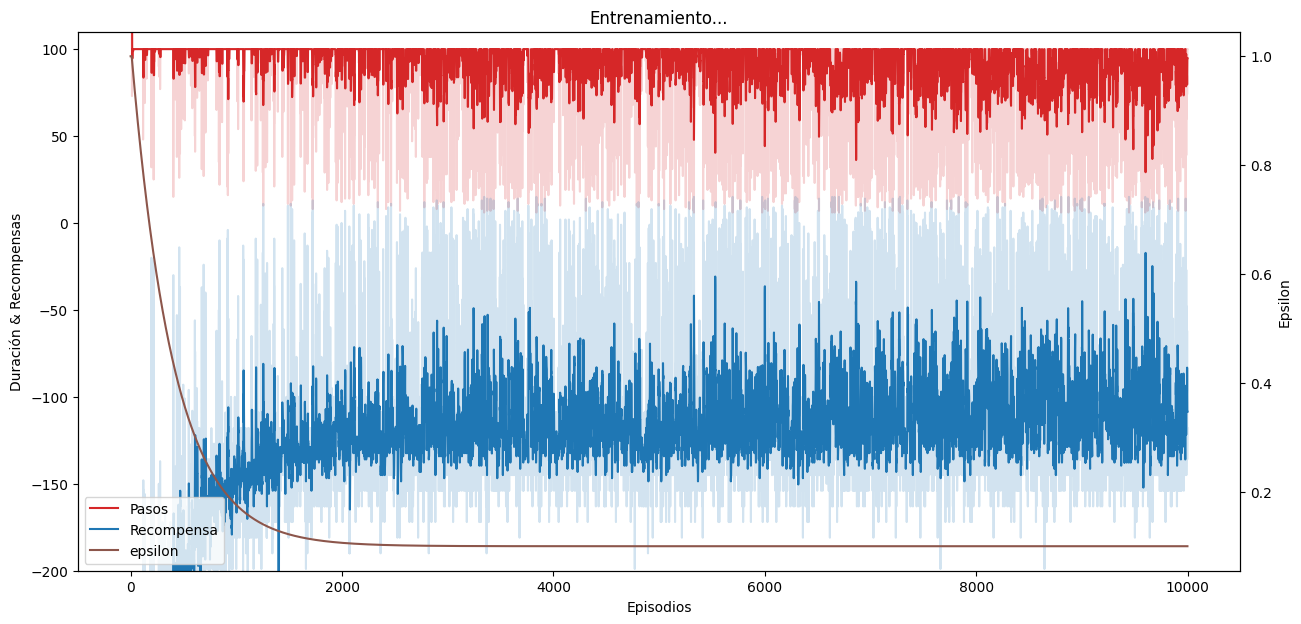

In [ ]:
env = gym.make("Taxi-v3").env
config = config_gamma_bajo
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Actualizacion_alta_2**

Se define un valor de actualizacion de 2

In [ ]:
config_update_alto = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 2,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-23-b30617a3d73f>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


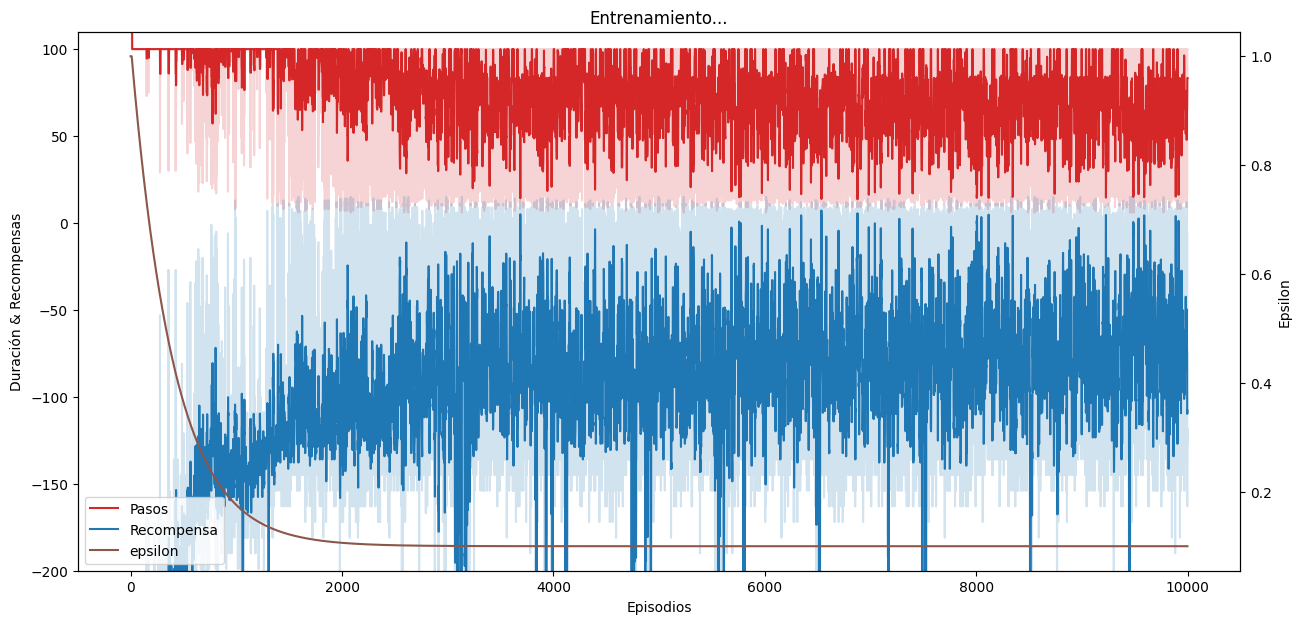

In [ ]:
env = gym.make("Taxi-v3").env
config = config_update_alto
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()

## **Actualizacion_Baja_200**

Se define un valor de actualizacion de 200.

In [ ]:
config_update_bajo = {
  "training":{
    "batch_size": 128,
    "learning_rate": 0.001,
    "loss": "huber",
    "num_episodes": 10000,
    "warmup_episode": 10,
    "save_freq": 1000
    },
  "optimizer":{
    "name": "adam",
    "lr_min": 0.0001,
    "lr_decay": 5000
    },
  "rl":{
    "gamma": 0.99,
    "max_steps_per_episode": 100,
    "target_model_update_episodes": 200,
    "max_queue_length": 50000
    },
  "epsilon":{
    "max_epsilon": 1,
    "min_epsilon": 0.1,
    "decay_epsilon": 400
    }
  }

  0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-23-b30617a3d73f>:238: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(15, 7))


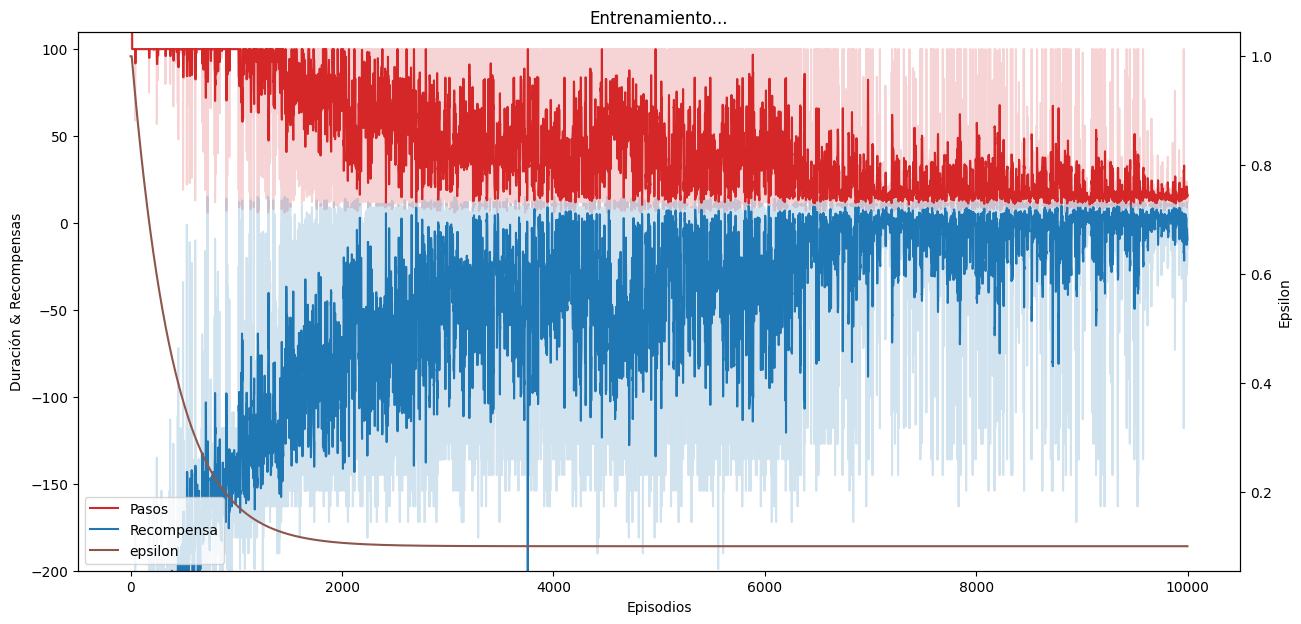

In [ ]:
env = gym.make("Taxi-v3").env
config = config_update_bajo
agent = QAgent(env=env, config=config, model_class=DQN)
agent.compile()
agent.fit()